### Урок 7#

### -- Автор: Шенк Евгений Станиславович

Запустить seq2seq без внимания, seq2seq с внимаием для перевода русских слов + описать наблюдения по качеству
Данные в папке data

### Выполнение:   
Обучены 2 модели seq2seq без внимания (нотбук из архива с занятия) и с вниманием (такой же нотбук, только с сайта Tensorflow без удаления внимания). 50 эпох.  
Переводы полученные с использованием внимания, получились гораздо лучше, хотя и не идеальные.  
Время обучения модели с вниманием получилось на ~60% дольше, чем без внимания.  
Результаты переводов с различными моделями находятся в конце нотбука.  

# Neural machine translation

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [2]:
# !wget http://www.manythings.org/anki/rus-eng.zip

In [3]:
# !mkdir rus-eng
# !unzip rus-eng.zip -d rus-eng/

In [4]:
# !ls /content/rus-eng/ -lah

In [5]:
# Download the file
path_to_file = "../data/content/rus-eng/rus.txt"

In [6]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [8]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [9]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [10]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                             padding='post')

    return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)


In [12]:
len(en), len(ru)

(392305, 392305)

In [13]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [15]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> я
630 ----> боюсь
790 ----> кошек
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
13 ----> i'm
244 ----> afraid
59 ----> of
451 ----> cats
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

## 1. No attention

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=False,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [24]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        # self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

In [27]:
decoder_sample_h.shape

TensorShape([64, 1024])

## Define the optimizer and the loss function

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [30]:
checkpoint_dir = './training_checkpoints/no_attention'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [32]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7452
Epoch 1 Batch 100 Loss 2.0768
Epoch 1 Batch 200 Loss 2.0103
Epoch 1 Batch 300 Loss 1.6176
Epoch 1 Batch 400 Loss 1.5127
Epoch 1 Batch 500 Loss 1.5004
Epoch 1 Batch 600 Loss 1.2426
Epoch 1 Batch 700 Loss 1.2518
Epoch 1 Batch 800 Loss 1.1869
Epoch 1 Batch 900 Loss 1.2251
Epoch 1 Batch 1000 Loss 1.2024
Epoch 1 Batch 1100 Loss 1.0132
Epoch 1 Batch 1200 Loss 1.0867
Epoch 1 Loss 1.4502
Time taken for 1 epoch 120.46971464157104 sec

Epoch 2 Batch 0 Loss 0.8925
Epoch 2 Batch 100 Loss 0.7740
Epoch 2 Batch 200 Loss 0.7769
Epoch 2 Batch 300 Loss 0.6699
Epoch 2 Batch 400 Loss 0.7893
Epoch 2 Batch 500 Loss 0.6893
Epoch 2 Batch 600 Loss 0.6924
Epoch 2 Batch 700 Loss 0.6324
Epoch 2 Batch 800 Loss 0.6196
Epoch 2 Batch 900 Loss 0.7331
Epoch 2 Batch 1000 Loss 0.6406
Epoch 2 Batch 1100 Loss 0.5486
Epoch 2 Batch 1200 Loss 0.6211
Epoch 2 Loss 0.7204
Time taken for 1 epoch 104.83162784576416 sec

Epoch 3 Batch 0 Loss 0.3409
Epoch 3 Batch 100 Loss 0.3338
Epoch 3 Batch 200 Loss 0.4

Epoch 18 Batch 1000 Loss 0.0710
Epoch 18 Batch 1100 Loss 0.0422
Epoch 18 Batch 1200 Loss 0.0528
Epoch 18 Loss 0.0637
Time taken for 1 epoch 111.85740256309509 sec

Epoch 19 Batch 0 Loss 0.0528
Epoch 19 Batch 100 Loss 0.0776
Epoch 19 Batch 200 Loss 0.0401
Epoch 19 Batch 300 Loss 0.0690
Epoch 19 Batch 400 Loss 0.0435
Epoch 19 Batch 500 Loss 0.0734
Epoch 19 Batch 600 Loss 0.0886
Epoch 19 Batch 700 Loss 0.0314
Epoch 19 Batch 800 Loss 0.0789
Epoch 19 Batch 900 Loss 0.1003
Epoch 19 Batch 1000 Loss 0.0619
Epoch 19 Batch 1100 Loss 0.1177
Epoch 19 Batch 1200 Loss 0.0655
Epoch 19 Loss 0.0624
Time taken for 1 epoch 112.2727997303009 sec

Epoch 20 Batch 0 Loss 0.0355
Epoch 20 Batch 100 Loss 0.0584
Epoch 20 Batch 200 Loss 0.0576
Epoch 20 Batch 300 Loss 0.0608
Epoch 20 Batch 400 Loss 0.0573
Epoch 20 Batch 500 Loss 0.1236
Epoch 20 Batch 600 Loss 0.0590
Epoch 20 Batch 700 Loss 0.0729
Epoch 20 Batch 800 Loss 0.0513
Epoch 20 Batch 900 Loss 0.0418
Epoch 20 Batch 1000 Loss 0.0658
Epoch 20 Batch 1100 Loss 

Epoch 36 Batch 100 Loss 0.0425
Epoch 36 Batch 200 Loss 0.0441
Epoch 36 Batch 300 Loss 0.0790
Epoch 36 Batch 400 Loss 0.0299
Epoch 36 Batch 500 Loss 0.0670
Epoch 36 Batch 600 Loss 0.0795
Epoch 36 Batch 700 Loss 0.0350
Epoch 36 Batch 800 Loss 0.0399
Epoch 36 Batch 900 Loss 0.0484
Epoch 36 Batch 1000 Loss 0.0675
Epoch 36 Batch 1100 Loss 0.0578
Epoch 36 Batch 1200 Loss 0.0434
Epoch 36 Loss 0.0492
Time taken for 1 epoch 111.39383220672607 sec

Epoch 37 Batch 0 Loss 0.0437
Epoch 37 Batch 100 Loss 0.0550
Epoch 37 Batch 200 Loss 0.0777
Epoch 37 Batch 300 Loss 0.0443
Epoch 37 Batch 400 Loss 0.0596
Epoch 37 Batch 500 Loss 0.0478
Epoch 37 Batch 600 Loss 0.0529
Epoch 37 Batch 700 Loss 0.0524
Epoch 37 Batch 800 Loss 0.0466
Epoch 37 Batch 900 Loss 0.0242
Epoch 37 Batch 1000 Loss 0.0377
Epoch 37 Batch 1100 Loss 0.0501
Epoch 37 Batch 1200 Loss 0.0588
Epoch 37 Loss 0.0492
Time taken for 1 epoch 109.4167411327362 sec

Epoch 38 Batch 0 Loss 0.0350
Epoch 38 Batch 100 Loss 0.0450
Epoch 38 Batch 200 Loss 0.

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [33]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [34]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

## 1. With attention

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

In [23]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [26]:
checkpoint_dir = './training_checkpoints/with_attention'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [28]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6826
Epoch 1 Batch 100 Loss 2.1219
Epoch 1 Batch 200 Loss 1.9130
Epoch 1 Batch 300 Loss 1.8220
Epoch 1 Batch 400 Loss 1.4942
Epoch 1 Batch 500 Loss 1.5151
Epoch 1 Batch 600 Loss 1.4444
Epoch 1 Batch 700 Loss 1.4265
Epoch 1 Batch 800 Loss 1.2142
Epoch 1 Batch 900 Loss 1.2207
Epoch 1 Batch 1000 Loss 1.1436
Epoch 1 Batch 1100 Loss 0.9878
Epoch 1 Batch 1200 Loss 0.9801
Epoch 1 Loss 1.5013
Time taken for 1 epoch 205.2399091720581 sec

Epoch 2 Batch 0 Loss 0.7096
Epoch 2 Batch 100 Loss 0.7971
Epoch 2 Batch 200 Loss 0.7484
Epoch 2 Batch 300 Loss 0.7563
Epoch 2 Batch 400 Loss 0.7998
Epoch 2 Batch 500 Loss 0.6278
Epoch 2 Batch 600 Loss 0.6339
Epoch 2 Batch 700 Loss 0.6309
Epoch 2 Batch 800 Loss 0.6551
Epoch 2 Batch 900 Loss 0.6286
Epoch 2 Batch 1000 Loss 0.6167
Epoch 2 Batch 1100 Loss 0.5281
Epoch 2 Batch 1200 Loss 0.5696
Epoch 2 Loss 0.6414
Time taken for 1 epoch 185.34209275245667 sec

Epoch 3 Batch 0 Loss 0.3538
Epoch 3 Batch 100 Loss 0.2943
Epoch 3 Batch 200 Loss 0.38

Epoch 18 Batch 1000 Loss 0.0717
Epoch 18 Batch 1100 Loss 0.0896
Epoch 18 Batch 1200 Loss 0.0755
Epoch 18 Loss 0.0571
Time taken for 1 epoch 172.08159923553467 sec

Epoch 19 Batch 0 Loss 0.0589
Epoch 19 Batch 100 Loss 0.0583
Epoch 19 Batch 200 Loss 0.0374
Epoch 19 Batch 300 Loss 0.0588
Epoch 19 Batch 400 Loss 0.0713
Epoch 19 Batch 500 Loss 0.0826
Epoch 19 Batch 600 Loss 0.0533
Epoch 19 Batch 700 Loss 0.0494
Epoch 19 Batch 800 Loss 0.0457
Epoch 19 Batch 900 Loss 0.0564
Epoch 19 Batch 1000 Loss 0.0903
Epoch 19 Batch 1100 Loss 0.1049
Epoch 19 Batch 1200 Loss 0.0880
Epoch 19 Loss 0.0563
Time taken for 1 epoch 170.8322319984436 sec

Epoch 20 Batch 0 Loss 0.0314
Epoch 20 Batch 100 Loss 0.0540
Epoch 20 Batch 200 Loss 0.0429
Epoch 20 Batch 300 Loss 0.0444
Epoch 20 Batch 400 Loss 0.0554
Epoch 20 Batch 500 Loss 0.0284
Epoch 20 Batch 600 Loss 0.0419
Epoch 20 Batch 700 Loss 0.0638
Epoch 20 Batch 800 Loss 0.0391
Epoch 20 Batch 900 Loss 0.0429
Epoch 20 Batch 1000 Loss 0.0435
Epoch 20 Batch 1100 Loss 

In [29]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [33]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [30]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

## 1. No attention

In [35]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [36]:
translate('Здесь хорошо.')

Input: <start> здесь хорошо . <end>
Predicted translation: here's the good one . <end> 


In [37]:
translate('Я не смогу поехать.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


In [38]:
translate(u'Вы еще дома?')

Input: <start> вы еще дома ? <end>
Predicted translation: are you still home ? <end> 


In [39]:
translate(u'Вы все еще дома?')

Input: <start> вы все еще дома ? <end>
Predicted translation: are you still home ? <end> 


In [40]:
translate(u'Попробуй сделать это.')

Input: <start> попробуй сделать это . <end>
Predicted translation: try to do that . <end> 


In [41]:
translate(u'Я люблю, когда идет снег.')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i like them and come . <end> 


In [42]:
translate(u'Я никогда такого не делаю.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i'm never doing that . <end> 


## 1. With attention

In [34]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> здесь хорошо . <end>
Predicted translation: it's good here . <end> 


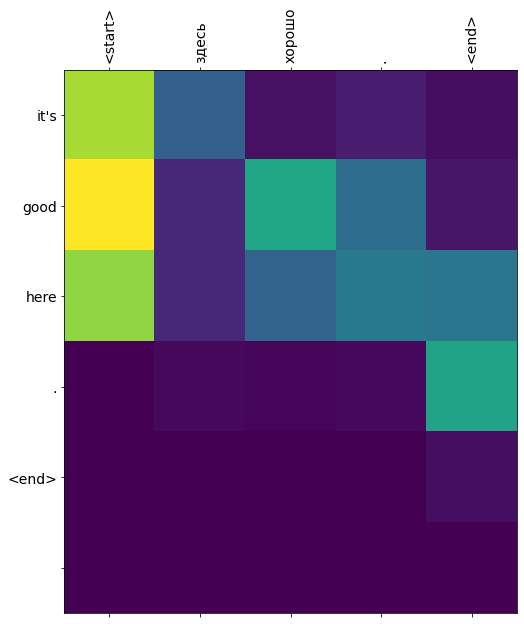

In [35]:
translate('Здесь хорошо.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


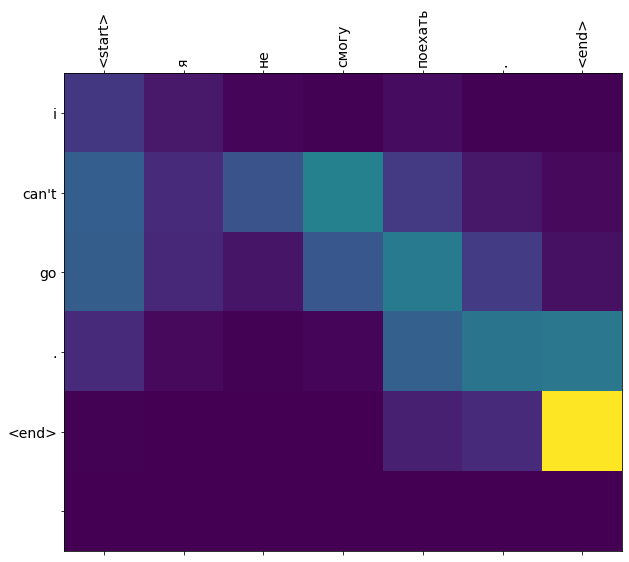

In [36]:
translate('Я не смогу поехать.')

Input: <start> вы еще дома ? <end>
Predicted translation: are you still home ? <end> 


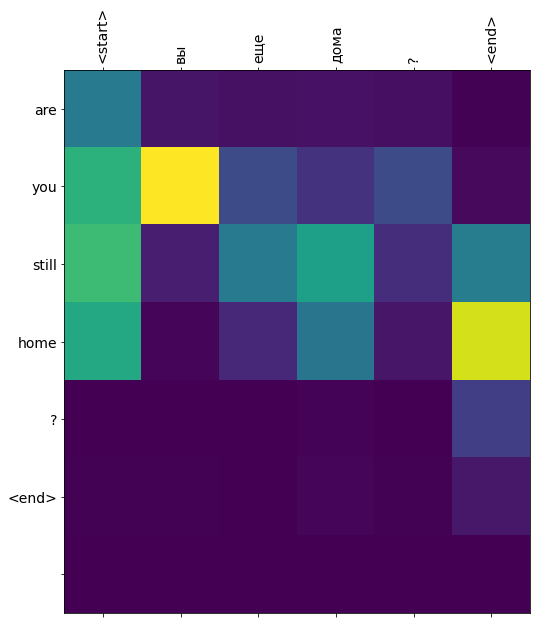

In [37]:
translate(u'Вы еще дома?')

Input: <start> вы все еще дома ? <end>
Predicted translation: are you still at home ? <end> 


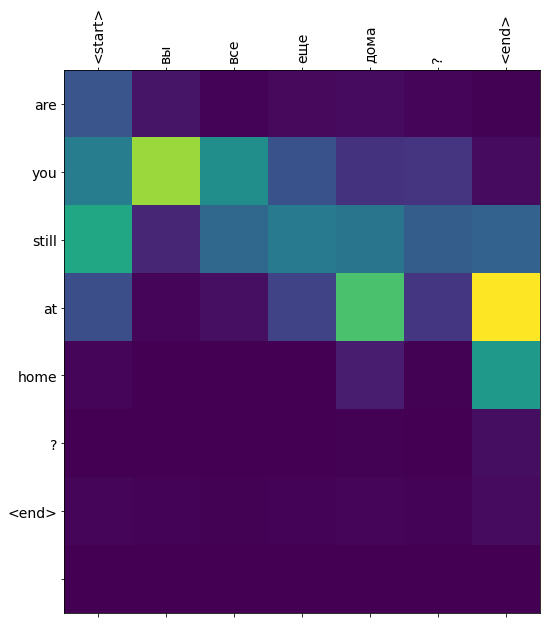

In [38]:
translate(u'Вы все еще дома?')

Input: <start> попробуй сделать это . <end>
Predicted translation: try to do that . <end> 


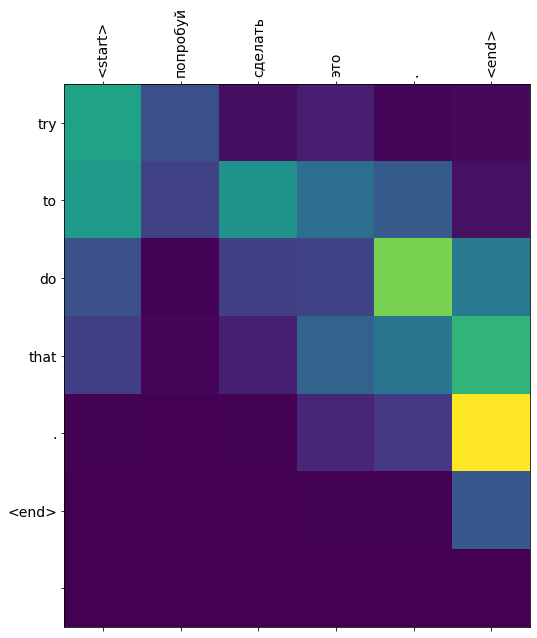

In [39]:
translate(u'Попробуй сделать это.')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i love him snow . <end> 


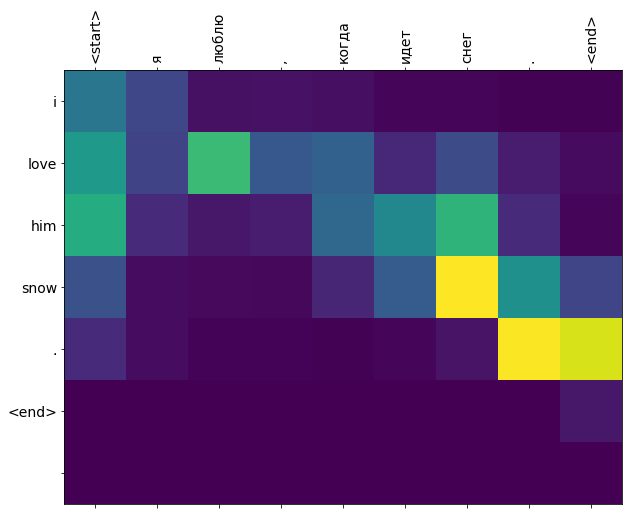

In [40]:
translate(u'Я люблю, когда идет снег.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


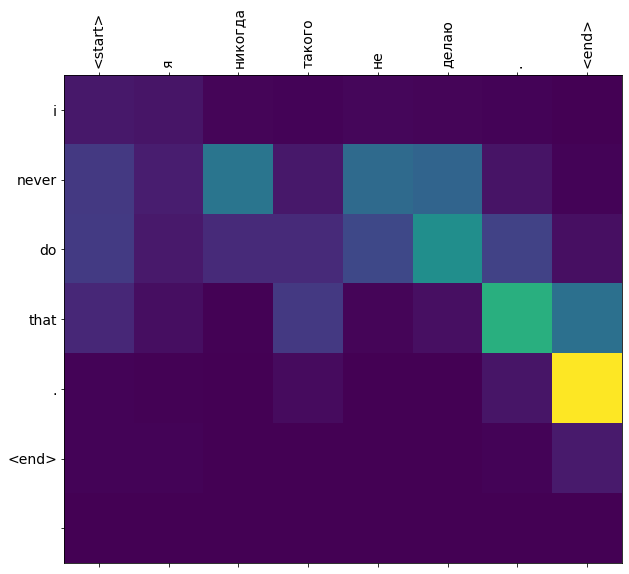

In [41]:
translate(u'Я никогда такого не делаю.')

## Изначально

In [ ]:
translate('Здесь хорошо.')

Input: <start> здесь хорошо . <end>
Predicted translation: it's part here . <end> 


In [ ]:
translate('Я не смогу поехать.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


In [ ]:
translate(u'Вы еще дома?')

Input: <start> вы еще дома ? <end>
Predicted translation: are you home alone ? <end> 


In [ ]:
translate(u'Вы все еще дома?')

Input: <start> вы все еще дома ? <end>
Predicted translation: can you still home ? <end> 


In [ ]:
translate(u'Попробуй сделать это.')

Input: <start> попробуй сделать это . <end>
Predicted translation: try to do that . <end> 


In [ ]:
translate(u'Я люблю, когда идет снег.')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i love how it will . <end> 


In [ ]:
translate(u'Я никогда такого не делаю.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 
